In [ ]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm import tqdm
from pulses_lib import multi_bit_rotation as pulse, generate_single_spin_state as bloch, make_operator_lists as oplists, printLists, reconstruct_state_L1, reconstruct_state_L1_LSQ



sns.set_style("whitegrid")

si = qt.qeye(2)
sx = qt.sigmax()
sy = qt.sigmay()
sz = qt.sigmaz()

Preverimo, če lahko v verigi iz $s_x$ in $s_y$ določimo $s_z$.


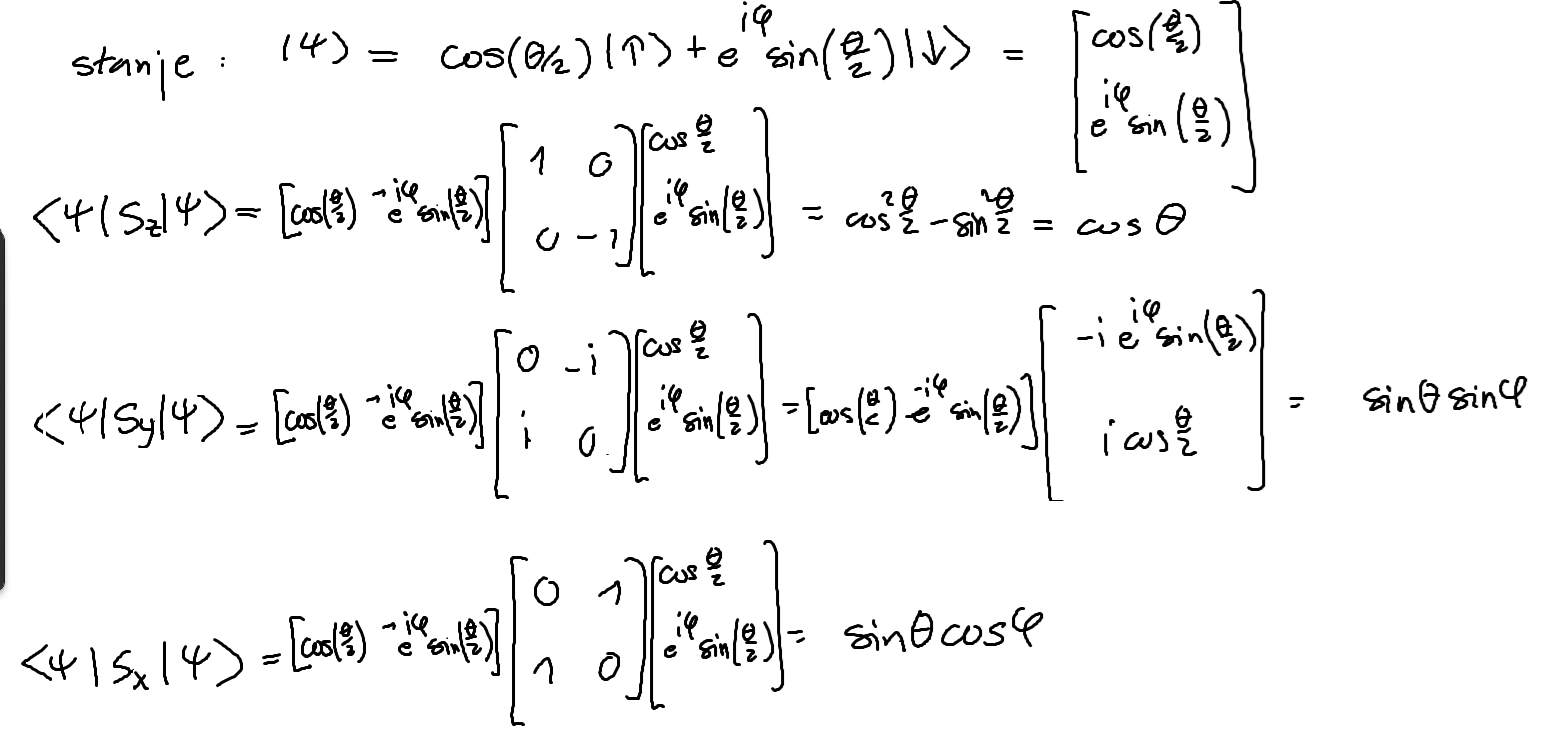

In [ ]:
phi = np.pi/3
theta = 2*np.pi/6
chain = qt.tensor([bloch(phi, theta)])
rho0 = chain * chain.dag()

x = qt.expect(sx,rho0)
y = qt.expect(sy,rho0)
z = qt.expect(sz,rho0)

print(f"z: {z},  {np.cos(theta/2)**2-np.sin(theta/2)**2}")
print(f"y: {y},  {np.sin(theta)*np.sin(phi)}")
print(f"x: {x},  {np.sin(theta)*np.cos(phi)}")

Iz $s_z$ in $s_y$ lahko $s_x$ določimo kot

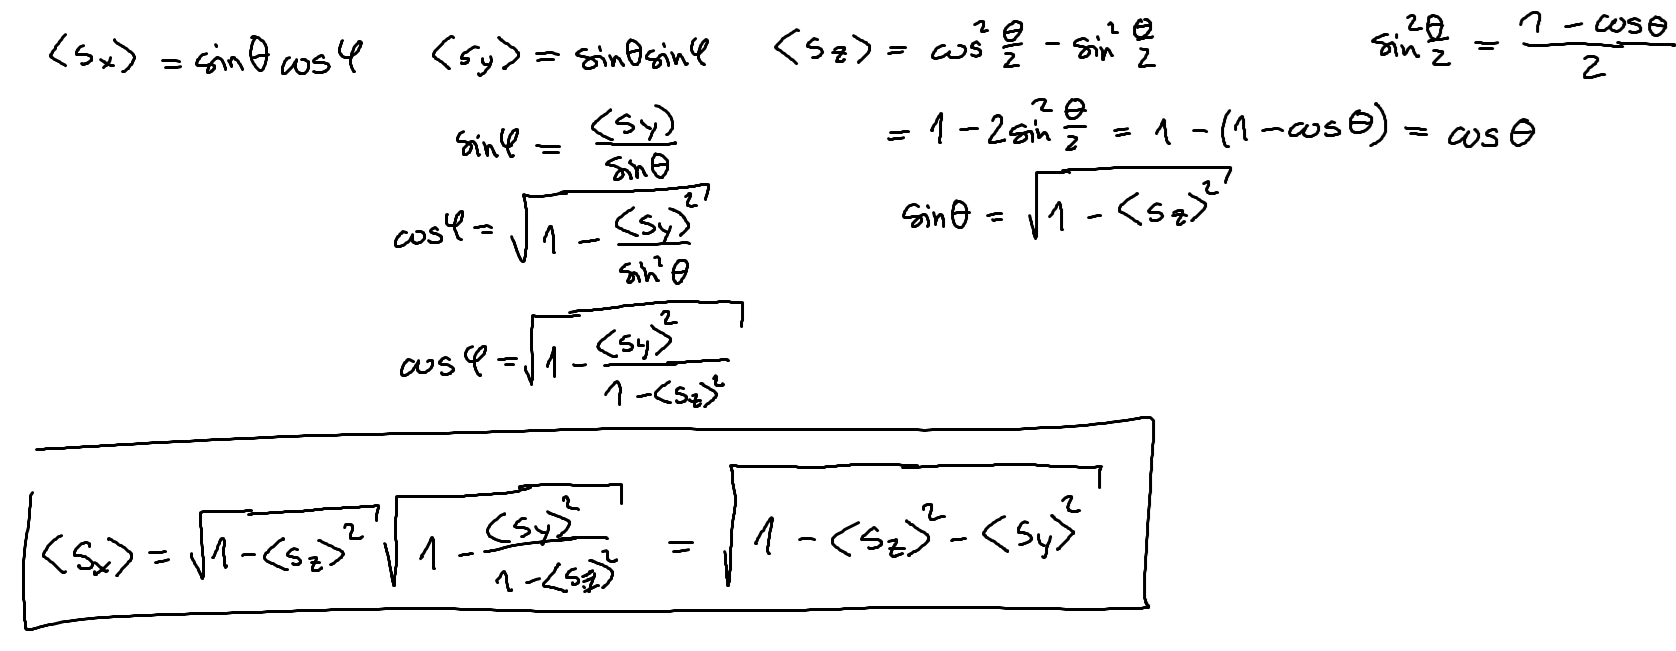

In [ ]:
def x_from_yz(y,z):
    return np.sqrt(1-np.square(z)-np.square(y))

In [ ]:
#Preverimo če to velja v verigi

N = 5
phi = [i for i in range(N)]
theta = [i for i in range(N)]
J = 100
hx = 0
hz = 0

sx_list, sy_list, sz_list = oplists(N)

chain = qt.tensor([bloch(phi[i], theta[i]) for i in range(N)])
rho = chain * chain.dag()

rho = pulse(N,J,hx,hz,rho,[["x", 0, [i for i in range(N)], 0]],0,1)

exactZ, exactY , exactX, predictedX = [], [], [], []
for i in range(N):
    exactX.append(qt.expect(sx_list[i], rho))
    exactY.append(qt.expect(sy_list[i], rho))
    exactZ.append(qt.expect(sz_list[i], rho))
    predictedX.append(x_from_yz(exactY[-1], exactZ[-1]))

printLists(["exactZ", "exactY", "exactX", "predictedX"], [exactZ, exactY, exactX, predictedX])
    



Direktna formula ne prepozna predznaka x

Če J ni enako 0 ne bo delovalo

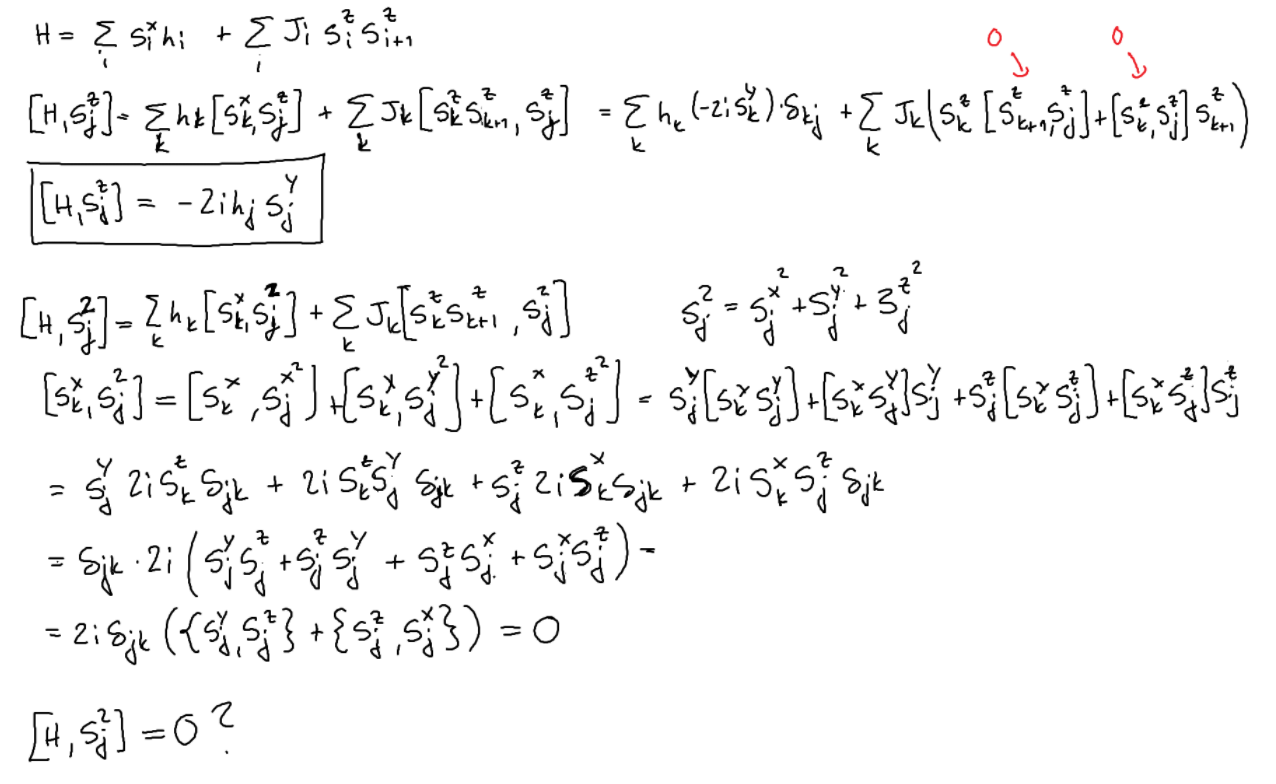

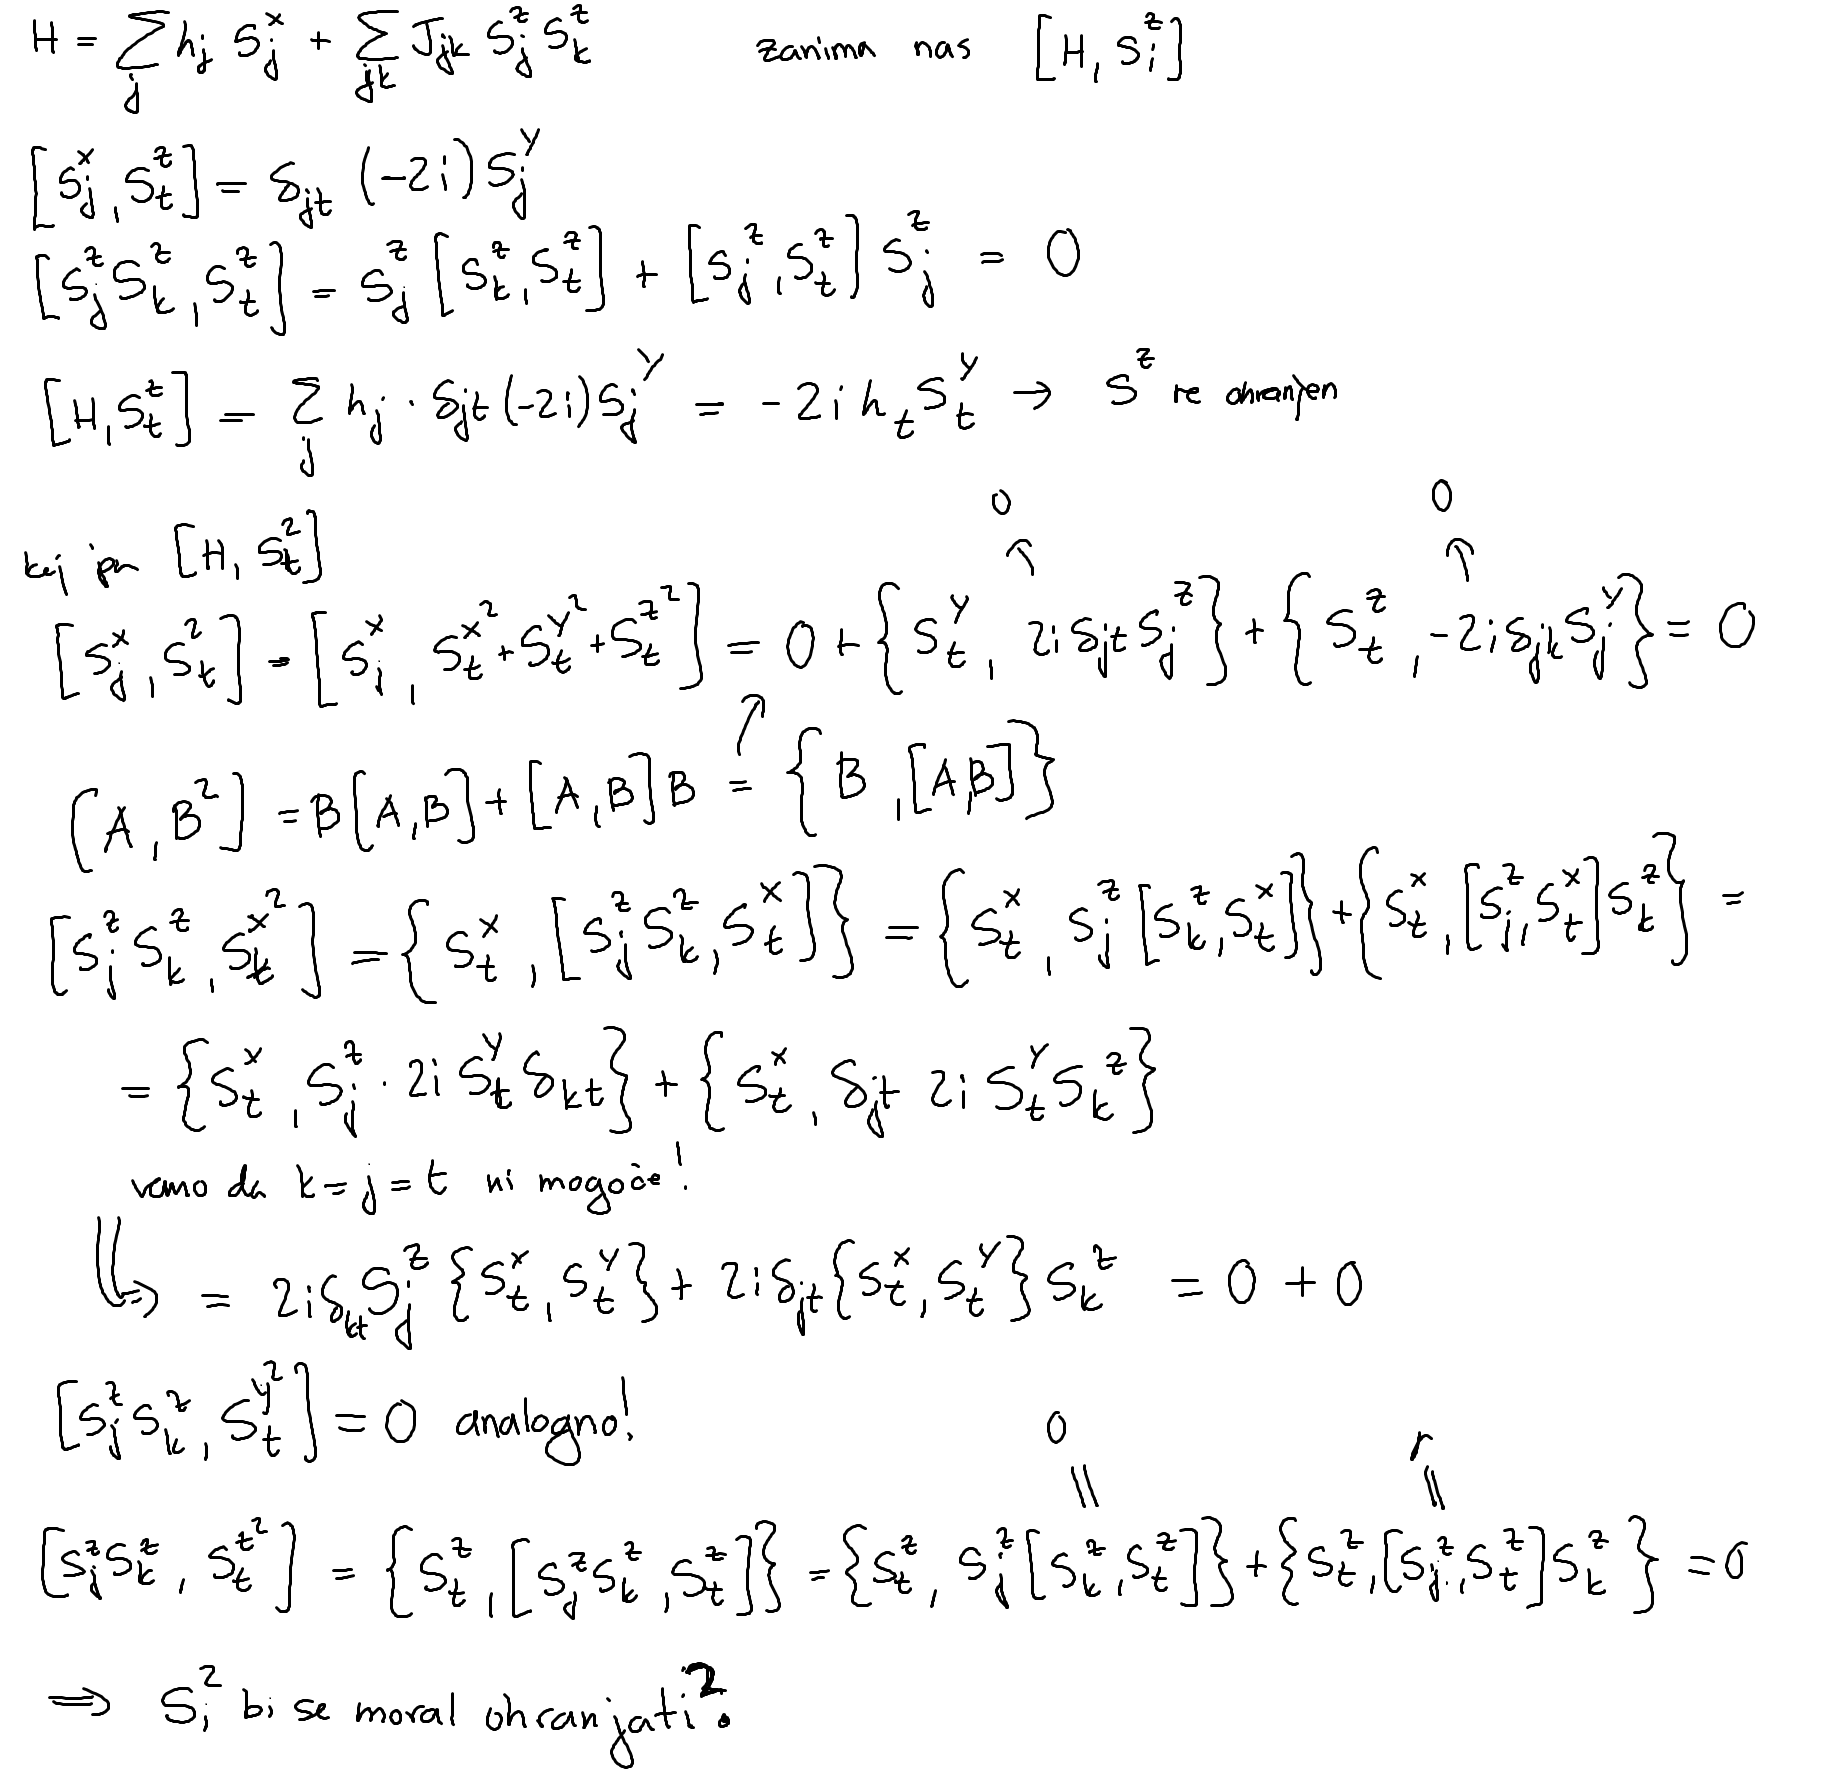

In [ ]:
#se res ohranja?
N = 5
phi = [i for i in range(N)]
theta = [i for i in range(N)]
J = 1000
hx = 1
hz = 0

sx_list, sy_list, sz_list = oplists(N)

s2_list = []
for i in range(N):
    s2_list.append(sx_list[i]*sx_list[i] + sy_list[i]*sy_list[i] + sz_list[i]*sz_list[i])

chain = qt.tensor([bloch(phi[i], theta[i]) for i in range(N)])
rho = chain * chain.dag()

print(qt.expect(s2_list[1], rho))

rho = pulse(N,J,hx,hz,rho,[["x", 0, [i for i in range(N)], 0]],0,1)

print(qt.expect(s2_list[1], rho))



Gremo zdaj na dejansko rekonstrukcijo stanja!


In [42]:
N = 6
phis = [np.pi/2 for i in range(N)]
thetas = [np.pi/2 for i in range(N)]
startstate = qt.tensor([bloch(phis[i], thetas[i]) for i in range(N)])
startstate = startstate * startstate.dag()

##do operation or something
hx = 0
hz = 0
J = 1
endstate = pulse(N,J,hx,hz,startstate,[["x", 0, [i for i in range(N)], 0]],0,1)

##Do measurements
sx_list, sy_list, sz_list = oplists(N)
exactZ, exactY , exactX = [], [], []
for i in range(N):
    exactX.append(qt.expect(sx_list[i], endstate))
    exactY.append(qt.expect(sy_list[i], endstate))
    exactZ.append(qt.expect(sz_list[i], endstate))

##Reconstruct state
substates = []
for i in range(N):
    theta = np.arccos(exactZ[i])
    if exactZ[i] != 1.0:
        phi = np.arccos(exactX[i] / np.sqrt(1-exactZ[i]**2))
    else:
        phi = 0
    
    substates.append(bloch(phi,theta))
newstate = qt.tensor(substates)
newstate = newstate * newstate.dag()

#print(endstate)
#print(newstate)

print(np.sqrt(np.real((endstate*newstate).tr())))

newZ, newY , newX = [], [], []
for i in range(N):
    newX.append(qt.expect(sx_list[i], newstate))
    newY.append(qt.expect(sy_list[i], newstate))
    newZ.append(qt.expect(sz_list[i], newstate))

printLists(["exactZ", "newZ", "exactY", "newY", "exactX", "newX"], [exactZ, newZ,  exactY, newY, exactX, newX])




0.3301243483680496
             exactZ     | newZ       | exactY     | newY       | exactX     | newX       | 
Spin 0:    |   0.000000 |   0.000000 |   0.173176 |   1.000000 |   0.000000 |   0.000000 | 
Spin 1:    |  -0.000000 |   0.000000 |   0.173176 |   1.000000 |   0.000000 |   0.000000 | 
Spin 2:    |  -0.000000 |   0.000000 |   0.173176 |   1.000000 |   0.000000 |   0.000000 | 
Spin 3:    |  -0.000000 |   0.000000 |   0.173176 |   1.000000 |   0.000000 |   0.000000 | 
Spin 4:    |   0.000000 |   0.000000 |   0.173176 |   1.000000 |   0.000000 |   0.000000 | 
Spin 5:    |   0.000000 |   0.000000 |   0.173176 |   1.000000 |   0.000000 |   0.000000 | 


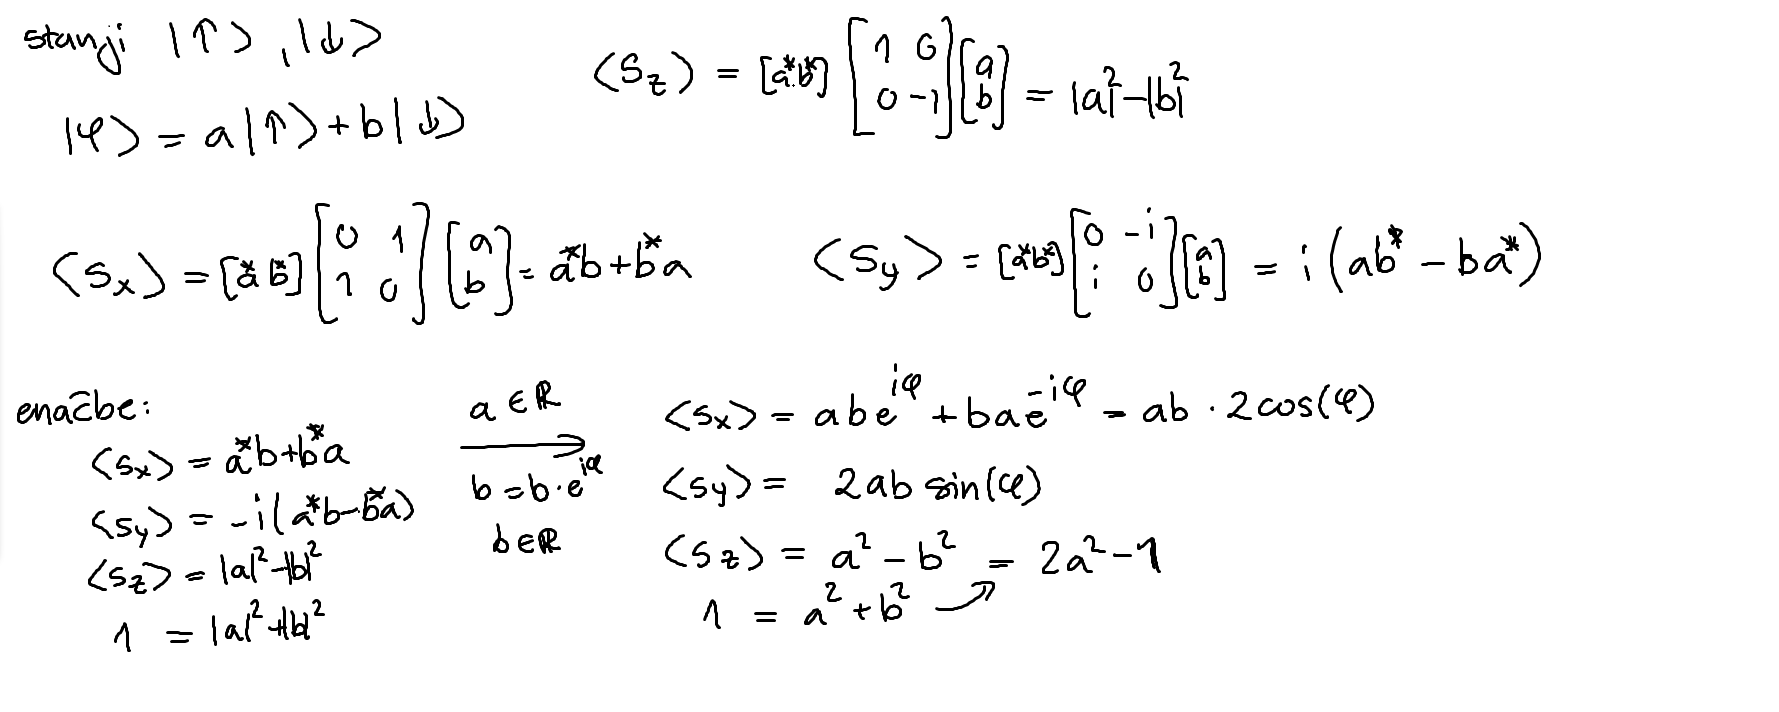

In [45]:
#Poskusimo še podoben model, le da vpletemo še y!

N = 6
phis = [np.pi/2 for i in range(N)]
thetas = [np.pi/2 for i in range(N)]
startstate = qt.tensor([bloch(phis[i], thetas[i]) for i in range(N)])
startstate = startstate * startstate.dag()

##do operation or something
hx = 1
hz = 0
J = 1
endstate = pulse(N,J,hx,hz,startstate,[["x", 0, [i for i in range(N)], 0]],0,1)

##Do measurements
sx_list, sy_list, sz_list = oplists(N)
exactZ, exactY , exactX = [], [], []
for i in range(N):
    exactX.append(qt.expect(sx_list[i], endstate))
    exactY.append(qt.expect(sy_list[i], endstate))
    exactZ.append(qt.expect(sz_list[i], endstate))

##Reconstruct state
newstate = reconstruct_state_L1_LSQ(endstate)


print(np.sqrt(np.real((endstate*newstate).tr())))

newZ, newY , newX = [], [], []
for i in range(N):
    newX.append(qt.expect(sx_list[i], newstate))
    newY.append(qt.expect(sy_list[i], newstate))
    newZ.append(qt.expect(sz_list[i], newstate))

printLists(["exactZ", "newZ", "exactY", "newY", "exactX", "newX"], [exactZ, newZ,  exactY, newY, exactX, newX])
    



0.8207536721455166
             exactZ     | newZ       | exactY     | newY       | exactX     | newX       | 
Spin 0:    |   0.005667 |   0.008487 |  -0.659078 |  -0.986521 |   0.109173 |   0.163416 | 
Spin 1:    |   0.005667 |   0.008487 |  -0.659078 |  -0.986521 |   0.109173 |   0.163416 | 
Spin 2:    |   0.005667 |   0.008487 |  -0.659078 |  -0.986521 |   0.109173 |   0.163416 | 
Spin 3:    |   0.005667 |   0.008487 |  -0.659078 |  -0.986521 |   0.109173 |   0.163416 | 
Spin 4:    |   0.005667 |   0.008487 |  -0.659078 |  -0.986521 |   0.109173 |   0.163416 | 
Spin 5:    |   0.005667 |   0.008487 |  -0.659078 |  -0.986521 |   0.109173 |   0.163416 | 
